In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
from os.path import join
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv', 'train_images', 'test_images']


In [2]:
# Import dependencies
import cv2
from tqdm import tqdm
from glob import glob
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
print("Tensorflow version: ", tf.__version__)

Tensorflow version:  1.14.0


Using TensorFlow backend.


In [3]:
# New image shape
IMG_SIZE = 128
BATCH_SIZE = 150
EPOCHS = 15
SAMPLING_SIZE = 500

Directories

In [4]:
# Base directory path
base_dir = join('..', 'input')

# Source images directory path
train_dir = join(base_dir, 'train_images')
print("Number of source train images: ", len(os.listdir(train_dir)))
test_dir = join(base_dir, 'test_images')
print("Number of source test images: ", len(os.listdir(test_dir)))

# Load train & test csv
train_df = pd.read_csv(join(base_dir, 'train.csv'))
test_df = pd.read_csv(join(base_dir, 'test.csv'))
print('Train_df shape: ', train_df.shape)
print('Test_df shape: ', test_df.shape)

Number of source train images:  3662
Number of source test images:  1928
Train_df shape:  (3662, 2)
Test_df shape:  (1928, 1)


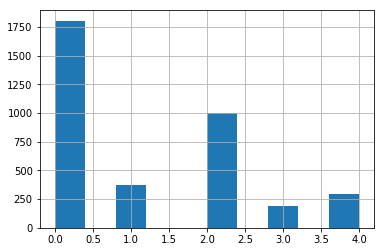

In [5]:
train_df['path'] = train_df['id_code'].map(
    lambda x: join(train_dir, '{}.png'.format(x))
)
test_df['path'] = test_df['id_code'].map(
    lambda x: join(test_dir, '{}.png'.format(x))
)
train_df.head(5)
train_df['diagnosis'].hist()

In [6]:
# Remove duplicates in training data
train_df = train_df.drop_duplicates()

# Over sampling
train_df = train_df.groupby(['diagnosis']).apply(lambda x: x.sample(SAMPLING_SIZE,
                                                             replace = True)).reset_index(drop=True)
train_df = shuffle(train_df)

# Train & validation split
train, validation = train_df.copy(), train_df.iloc[:int(train_df.shape[0]*0.15), ]
print('Train & Test split done...')
print("Shape;\nTrain: {}\nTest: {}\n-----".format(train.shape, validation.shape))

Train & Test split done...
Shape;
Train: (2500, 3)
Test: (375, 3)
-----


3    500
1    500
4    500
2    500
0    500
Name: diagnosis, dtype: int64

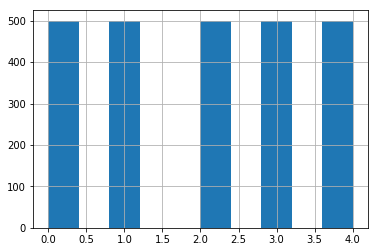

In [7]:
train_df['diagnosis'].hist()
train_df['diagnosis'].value_counts()

Image pre-processing

In [8]:
def img_preprocess(img_path, new_size=IMG_SIZE):
    img = cv2.imread(img_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (new_size, )*2).astype(np.uint8)
#     img = cv2.applyColorMap(img, cv2.COLORMAP_BONE)
#     img = cv2.addWeighted(img, 4,
#                           cv2.GaussianBlur(img, (0, 0),
#                                            IMG_SIZE/10), -4, 128)
    return img

In [9]:
x_train = np.empty((train.shape[0], 
                    IMG_SIZE, IMG_SIZE, 3),
                   dtype=np.float16)
for i, img_path in enumerate(tqdm(train['path'])):
    x_train[i, :, :, :] = img_preprocess(img_path)
x_train /= 255
y_train = train['diagnosis']

print("Testing images reading...")
x_val = np.empty((validation.shape[0],
                  IMG_SIZE, IMG_SIZE, 3),
                 dtype=np.float16)
for i, img_path in enumerate(tqdm(validation['path'])):
    x_val[i, :, :, :] = img_preprocess(img_path)
x_val /= 255
y_val = validation['diagnosis']

  0%|          | 0/375 [00:00<?, ?it/s]

Testing images reading...


100%|██████████| 375/375 [00:37<00:00,  9.55it/s]


Load Pre-trained model as base model

In [10]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
model_path = join('/', 'tmp', '.keras', 'models', '*.h5')
model_path = glob(model_path)
if False:
    print("Loading from local...")
    base_model = tf.keras.models.load_model(model_path[-1])
else:
    print("Downloading model...")
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=IMG_SHAPE,
        include_top=False,
        weights='imagenet'
    )

# Free base model weights
base_model.trainable = False

# Base model summary
base_model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
________________

In [11]:
# Add new-layers on top of base model
model = tf.keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(5, activation=tf.nn.softmax)
])

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [12]:
# Train generator
train_gen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
).flow(
    x_train, y_train, batch_size=BATCH_SIZE
)

# Validation generator
val_gen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
).flow(
    x_val, y_val, batch_size=BATCH_SIZE
)

Epoch 2/15
16/16 [==============================] - 57s 4s/step - loss: 1.7948 - acc: 0.2349 - val_loss: 1.6810 - val_acc: 0.1533
Epoch 3/15
16/16 [==============================] - 52s 3s/step - loss: 1.7208 - acc: 0.2455 - val_loss: 1.6786 - val_acc: 0.1767
Epoch 4/15
16/16 [==============================] - 51s 3s/step - loss: 1.6161 - acc: 0.2962 - val_loss: 1.6727 - val_acc: 0.1767
Epoch 5/15
16/16 [==============================] - 51s 3s/step - loss: 1.5605 - acc: 0.3187 - val_loss: 1.6632 - val_acc: 0.1767
Epoch 6/15
16/16 [==============================] - 51s 3s/step - loss: 1.5086 - acc: 0.3283 - val_loss: 1.6592 - val_acc: 0.1767
Epoch 7/15
16/16 [==============================] - 51s 3s/step - loss: 1.4493 - acc: 0.3817 - val_loss: 1.6541 - val_acc: 0.2400
Epoch 8/15
16/16 [==============================] - 50s 3s/step - loss: 1.3976 - acc: 0.4017 - val_loss: 1.6418 - val_acc: 0.2633
Epoch 9/15
16/16 [==============================] - 52s 3s/step - loss: 1.3825 - acc: 0.41

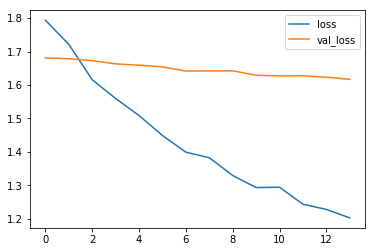

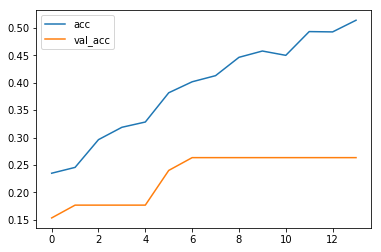

In [13]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=train_gen.n//BATCH_SIZE,
    epochs=EPOCHS,
    shuffle=True,
    initial_epoch=1,
    validation_data=val_gen,
    validation_steps=val_gen.n//BATCH_SIZE
)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

In [14]:
# Load testing images
x_test = np.empty((test_df.shape[0], IMG_SIZE, IMG_SIZE, 3),
                  dtype=np.float16)
for i, img_path in enumerate(tqdm(test_df['path'])):
    x_test[i, :, : , :] = img_preprocess(img_path)
x_test /= 255

100%|██████████| 1928/1928 [00:59<00:00, 32.44it/s]


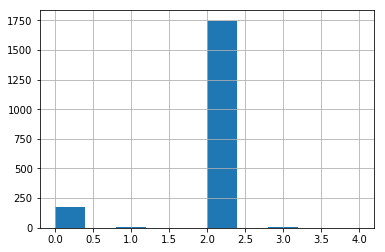

In [15]:
# Prediction
predictions = model.predict(
    x=x_test,
    batch_size=BATCH_SIZE
)
test_df['diagnosis'] = predictions.astype('float').argmax(axis=1)
pred_df = test_df[['id_code', 'diagnosis']]

# Save predictions
pred_df.to_csv('submission.csv', index=False)
pred_df['diagnosis'].hist()